In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Dataset

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from scipy import stats

# Set device to GPU if available on Kaggle

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


# 1. DATA LOADING & IMBALANCE HANDLING

In [3]:
# IMPORTANT: Update this path to point to your specific Kaggle dataset directory
data_dir = '/kaggle/input/datasets/fernando2rad/brain-tumor-mri-images-44c'

# Standard ImageNet transforms required for EfficientNet architectures

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# Helper class to apply different transforms to train/val splits
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [6]:
# Load the entire dataset WITHOUT transforms initially
full_dataset = datasets.ImageFolder(data_dir)
class_names = full_dataset.classes
num_classes = len(class_names)

# Split the dataset (80% training, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
# Using a manual seed ensures reproducibility across runs
train_subset, val_subset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

In [7]:
# Apply the specific transforms to each split
image_datasets = {
    'train': DatasetFromSubset(train_subset, transform=data_transforms['train']),
    'val': DatasetFromSubset(val_subset, transform=data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=2)
}

# Compute Class Weights to penalize the model for missing minority classes

In [8]:
# Compute Class Weights for the highly imbalanced training set
# We extract the targets corresponding only to the indices in our training subset
train_targets = [full_dataset.targets[i] for i in train_subset.indices]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_targets), y=train_targets)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Dataset loaded: {train_size} training images, {val_size} validation images.")

Dataset loaded: 3583 training images, 896 validation images.


# 2. MODEL DEFINITION (TRANSFER LEARNING)

# Load pre-trained EfficientNetV2-S

In [9]:
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 181MB/s]


# Freeze initial layers for feature extraction

In [10]:
for param in model.parameters():
    param.requires_grad = False

# Fine-tune the final classification layer for 44 classes

In [11]:
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Apply the calculated class weights directly to the loss function

In [12]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)

# 3. TRAINING LOOP (WITH TIME TRACKING)

In [13]:
num_epochs = 50

train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

print("\n--- Starting Training ---")
train_start_time = time.time()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])
        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc.item())
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc.item())
    print()

train_end_time = time.time()
total_train_time = train_end_time - train_start_time
print(f"Total Training Time: {total_train_time // 60:.0f}m {total_train_time % 60:.0f}s\n")


--- Starting Training ---
Epoch 1/50
----------
Train Loss: 3.1812 Acc: 0.2933
Val Loss: 2.5775 Acc: 0.4699

Epoch 2/50
----------
Train Loss: 2.2799 Acc: 0.4937
Val Loss: 2.0983 Acc: 0.5179

Epoch 3/50
----------
Train Loss: 1.8898 Acc: 0.5481
Val Loss: 1.8718 Acc: 0.5513

Epoch 4/50
----------
Train Loss: 1.6697 Acc: 0.5749
Val Loss: 1.7328 Acc: 0.5435

Epoch 5/50
----------
Train Loss: 1.4825 Acc: 0.5934
Val Loss: 1.6257 Acc: 0.5714

Epoch 6/50
----------
Train Loss: 1.4313 Acc: 0.5975
Val Loss: 1.5489 Acc: 0.5804

Epoch 7/50
----------
Train Loss: 1.3068 Acc: 0.6229
Val Loss: 1.4789 Acc: 0.5826

Epoch 8/50
----------
Train Loss: 1.2488 Acc: 0.6322
Val Loss: 1.4464 Acc: 0.5882

Epoch 9/50
----------
Train Loss: 1.1688 Acc: 0.6517
Val Loss: 1.4086 Acc: 0.6116

Epoch 10/50
----------
Train Loss: 1.1213 Acc: 0.6606
Val Loss: 1.3463 Acc: 0.6116

Epoch 11/50
----------
Train Loss: 1.0699 Acc: 0.6631
Val Loss: 1.3324 Acc: 0.6217

Epoch 12/50
----------
Train Loss: 1.0491 Acc: 0.6782
Val 

# TRAINING CURVES

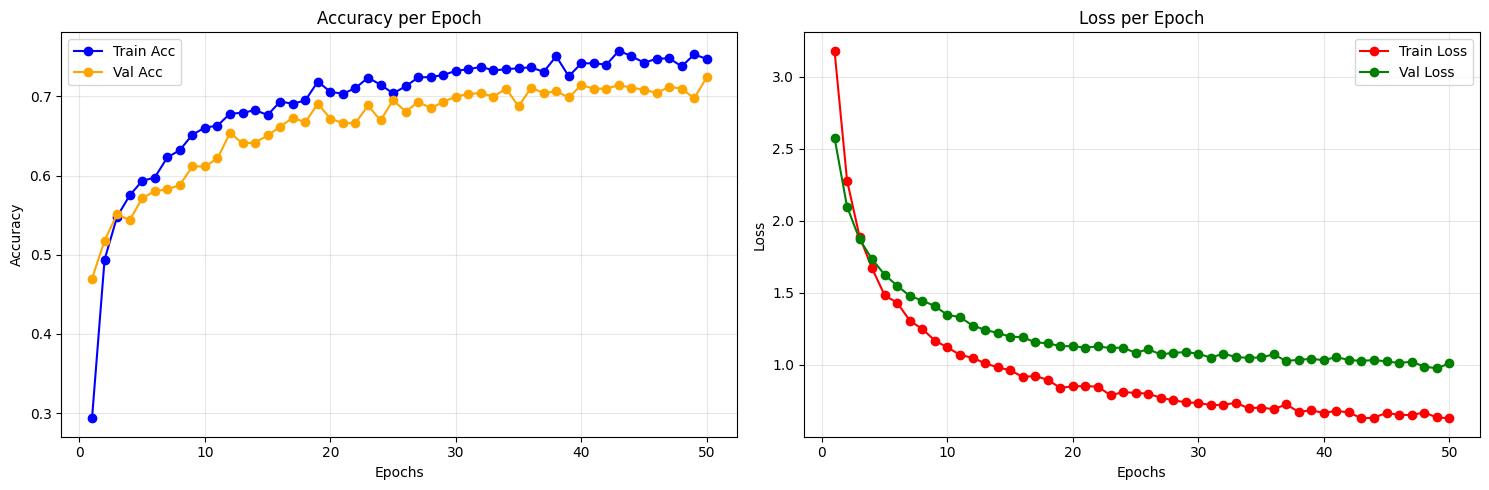

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(1, num_epochs + 1), train_acc_history, label='Train Acc', color='blue', marker='o')
ax1.plot(range(1, num_epochs + 1), val_acc_history, label='Val Acc', color='orange', marker='o')
ax1.set_title('Accuracy per Epoch')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss', color='red', marker='o')
ax2.plot(range(1, num_epochs + 1), val_loss_history, label='Val Loss', color='green', marker='o')
ax2.set_title('Loss per Epoch')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. EVALUATION & METRICS

In [15]:
print("\n--- Starting Evaluation ---")
test_start_time = time.time()
model.eval()

y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

test_end_time = time.time()
total_test_time = test_end_time - test_start_time
time_per_image = (total_test_time / len(dataloaders['val'].dataset)) * 1000

print(f"Total Testing Time: {total_test_time:.2f} seconds")
print(f"Inference Time per Image: {time_per_image:.2f} ms\n")

y_probs = np.array(y_probs)
y_true_bin = label_binarize(y_true, classes=range(num_classes))


--- Starting Evaluation ---
Total Testing Time: 3.84 seconds
Inference Time per Image: 4.29 ms



In [16]:
# 1. Overall Accuracy, Precision, Recall, F1-Score, and Class Accuracy
# The classification report outputs all of these natively (Class Accuracy = the Recall for each specific class)
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)

Classification Report:
                         precision    recall  f1-score   support

        Astrocitoma T1       0.92      0.73      0.81        45
      Astrocitoma T1C+       0.74      0.70      0.72        44
        Astrocitoma T2       0.50      0.52      0.51        25
          Carcinoma T1       0.92      0.92      0.92        12
        Carcinoma T1C+       0.81      0.85      0.83        20
          Carcinoma T2       0.71      0.83      0.77        12
         Ependimoma T1       0.89      0.62      0.73        13
       Ependimoma T1C+       0.38      0.75      0.50         8
         Ependimoma T2       0.75      0.75      0.75        12
      Ganglioglioma T1       0.50      1.00      0.67         2
    Ganglioglioma T1C+       0.38      0.60      0.46         5
      Ganglioglioma T2       0.50      0.50      0.50         4
          Germinoma T1       0.45      1.00      0.62         5
        Germinoma T1C+       0.38      0.83      0.53         6
          Germi

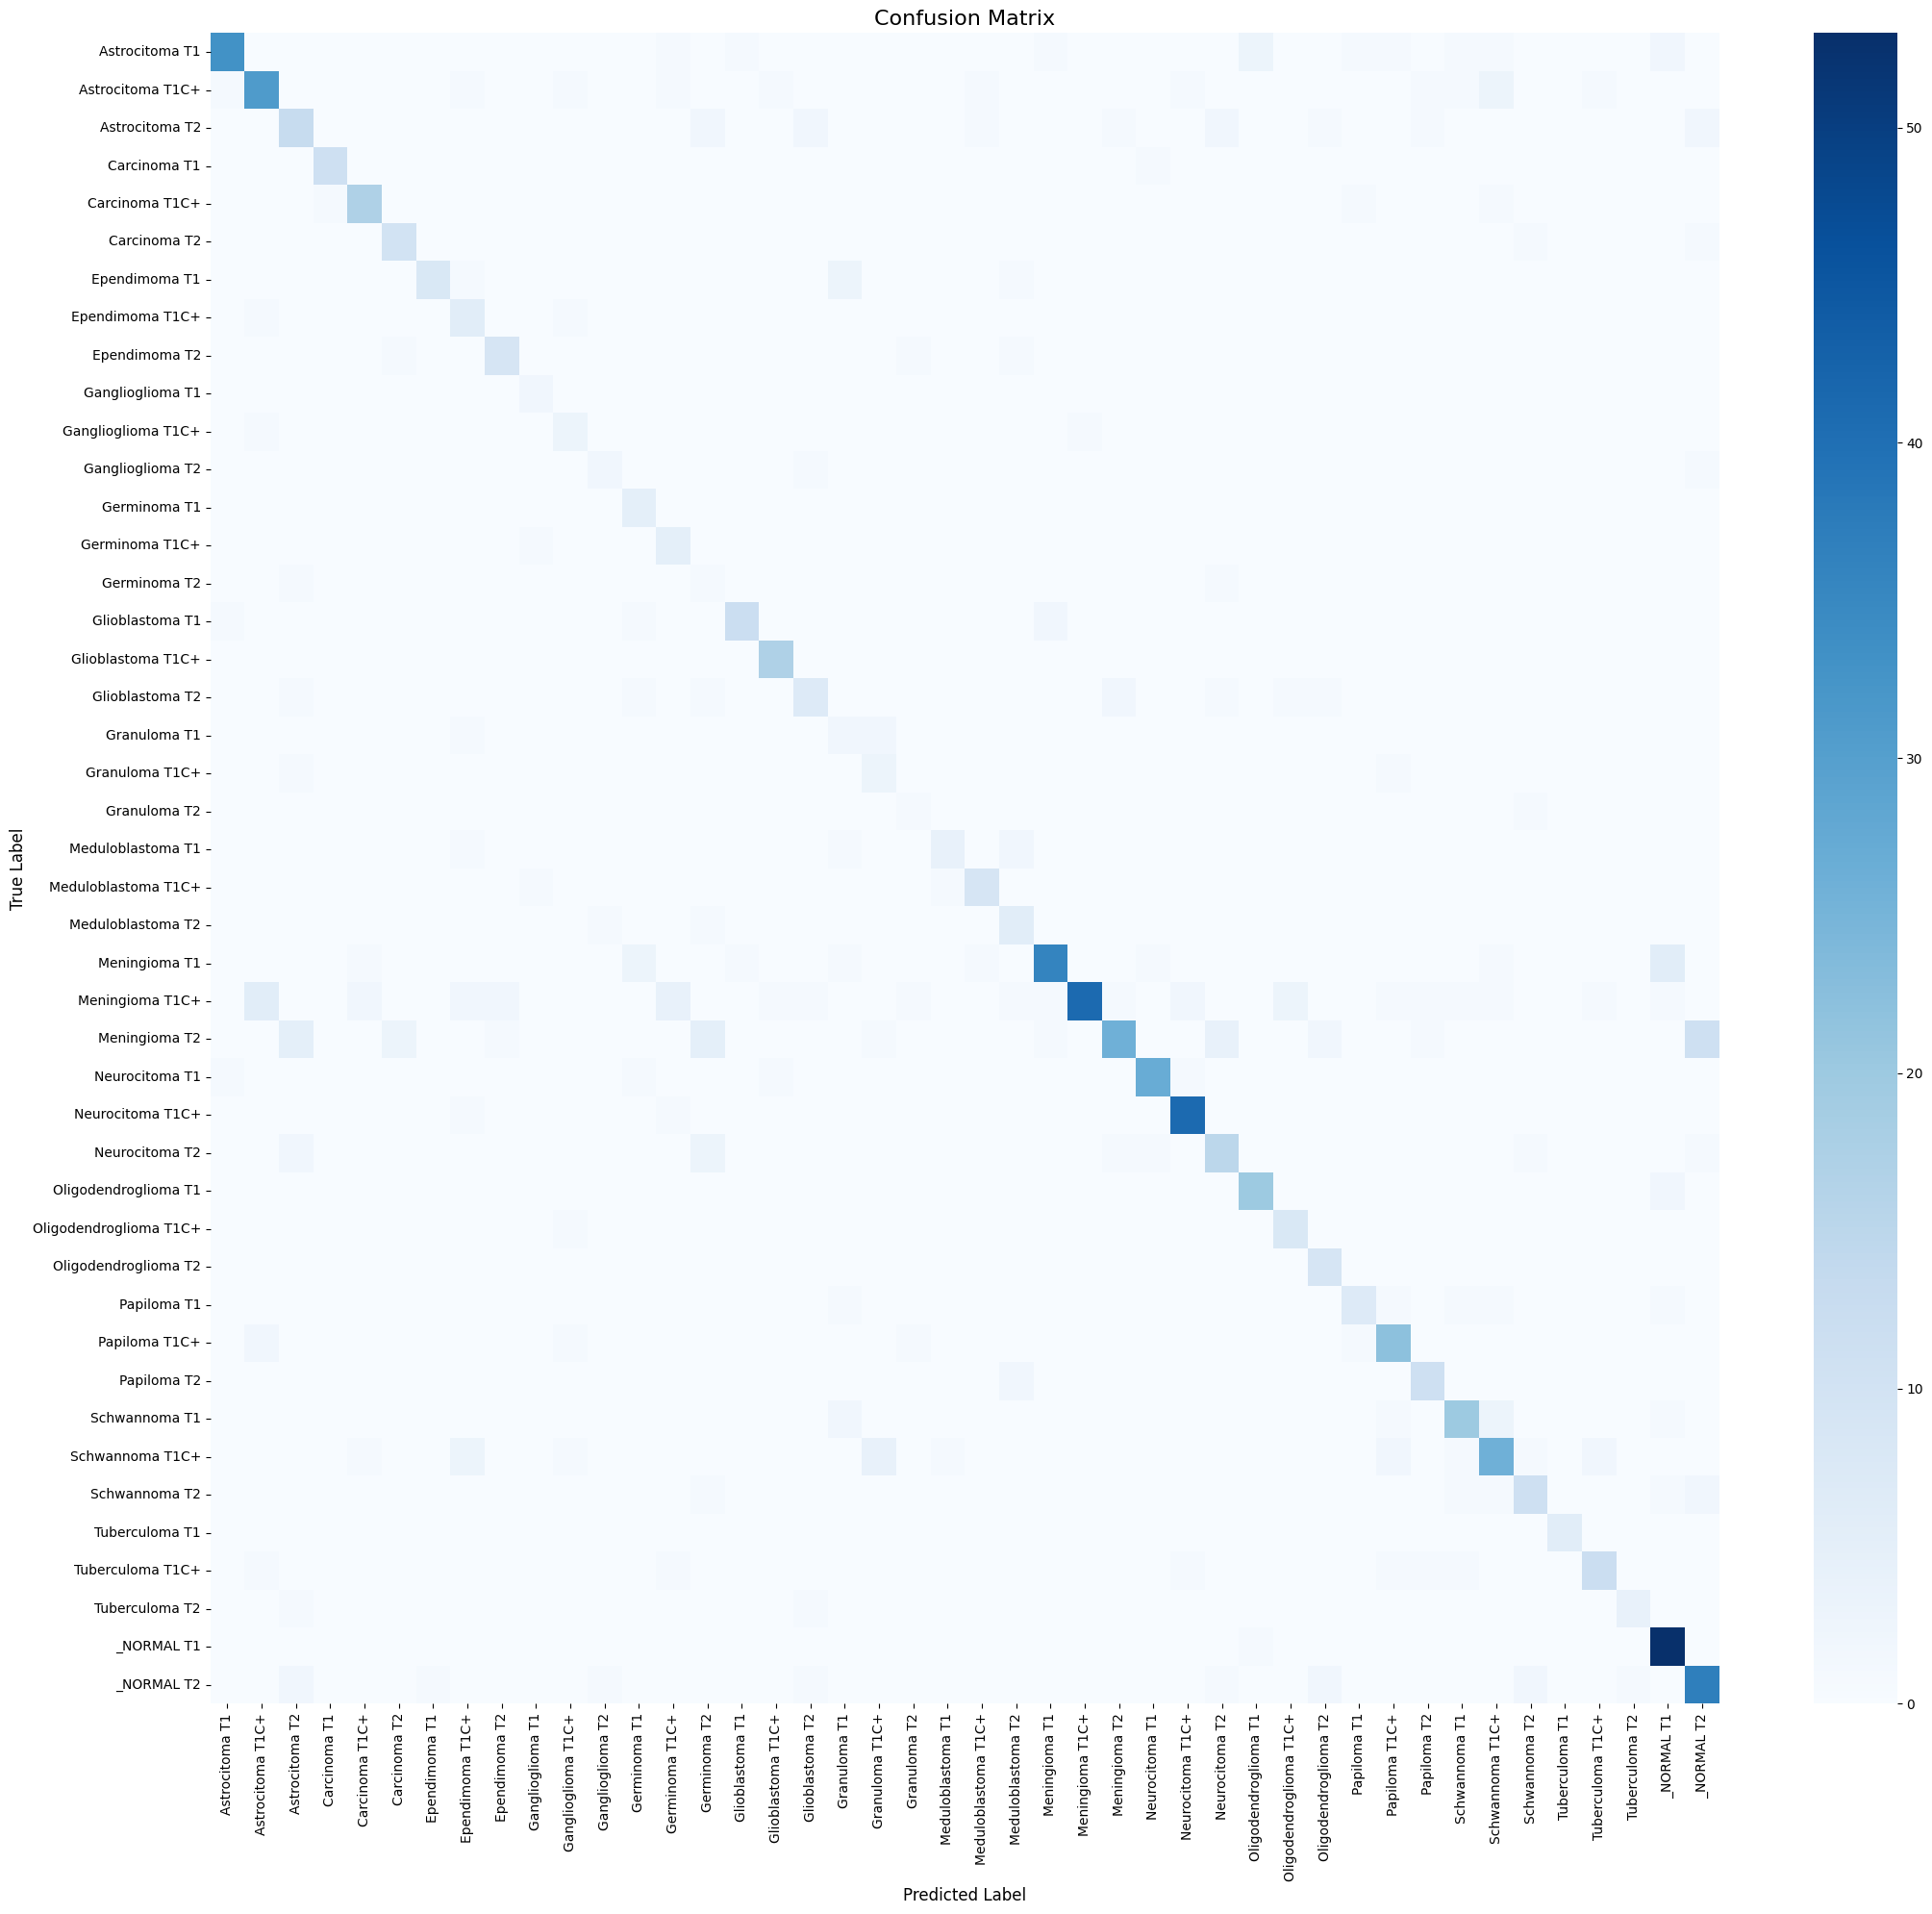

In [17]:
# 2. Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(22, 20))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
# 3. AUC and ROC Curve 
macro_auc = roc_auc_score(y_true, y_probs, multi_class='ovr', average='macro')
print(f"\nOverall Macro-Averaged AUC Score: {macro_auc:.4f}")





Overall Macro-Averaged AUC Score: 0.9844


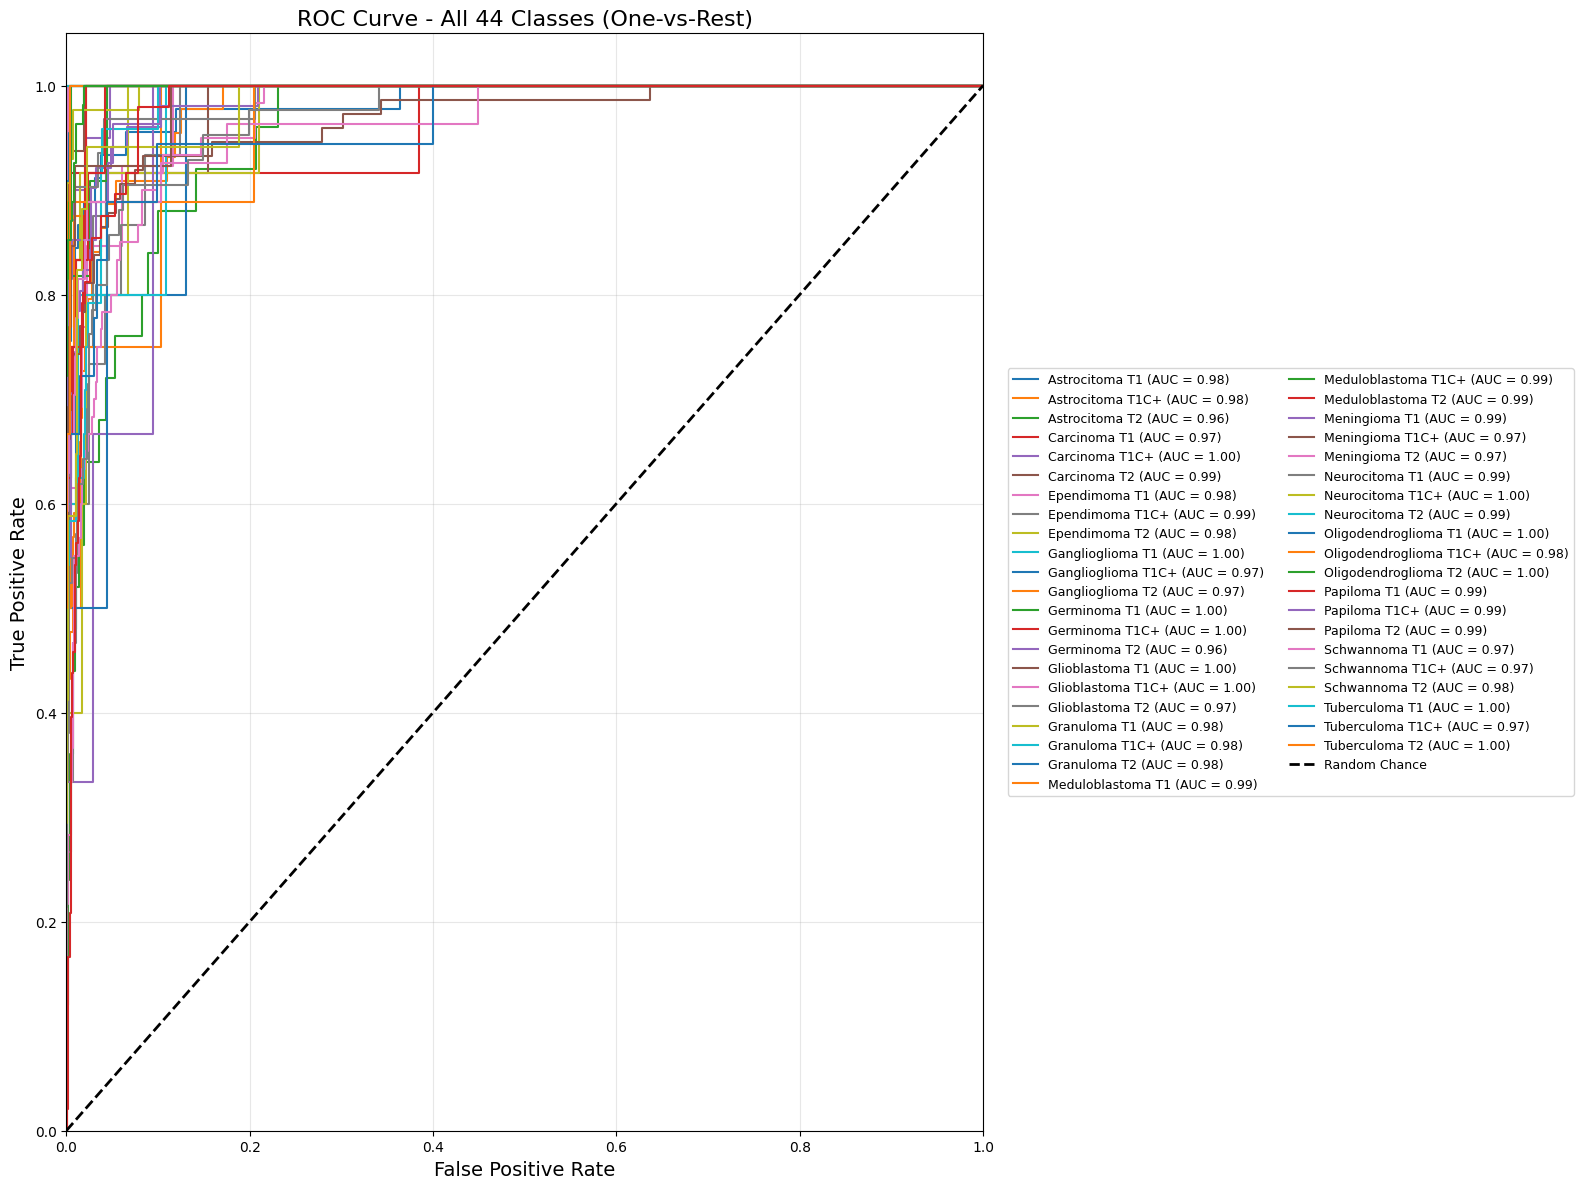

In [19]:

plt.figure(figsize=(16, 12)) # Very large figure to accommodate 44 lines
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    # Plot each line. We use a thin line (lw=1) so it doesn't become a massive blob of color
    plt.plot(fpr, tpr, lw=1.5, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve - All 44 Classes (One-vs-Rest)', fontsize=16)

# Place legend completely outside the plot to the right
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Map the 44 detailed labels to their 15 base disease names
# class_names[label] turns the numeric ID (0-43) back into the string name
# .split(' ')[0] cuts off the " T1" or " T1C+" part
base_y_true = [class_names[label].split(' ')[0] for label in y_true]
base_y_pred = [class_names[label].split(' ')[0] for label in y_pred]

# Extract the unique, sorted list of the base diseases
base_class_names = sorted(list(set(base_y_true)))

# 2. Print the Base Disease Classification Report
print("--- Base Disease Classification Report ---")
# We no longer use zero_division=0 here to expose if any parent class is completely missed
print(classification_report(base_y_true, base_y_pred, labels=base_class_names))



--- Base Disease Classification Report ---
                   precision    recall  f1-score   support

      Astrocitoma       0.75      0.68      0.72       114
        Carcinoma       0.83      0.89      0.86        44
       Ependimoma       0.65      0.73      0.69        33
    Ganglioglioma       0.44      0.64      0.52        11
        Germinoma       0.29      0.79      0.42        14
     Glioblastoma       0.77      0.75      0.76        48
        Granuloma       0.33      0.67      0.44        12
   Meduloblastoma       0.71      0.81      0.76        27
       Meningioma       0.93      0.57      0.71       185
      Neurocitoma       0.85      0.87      0.86        98
Oligodendroglioma       0.73      0.93      0.81        40
         Papiloma       0.75      0.81      0.78        52
       Schwannoma       0.78      0.74      0.76        86
      Tuberculoma       0.81      0.73      0.77        30
          _NORMAL       0.74      0.88      0.80       102

         ac

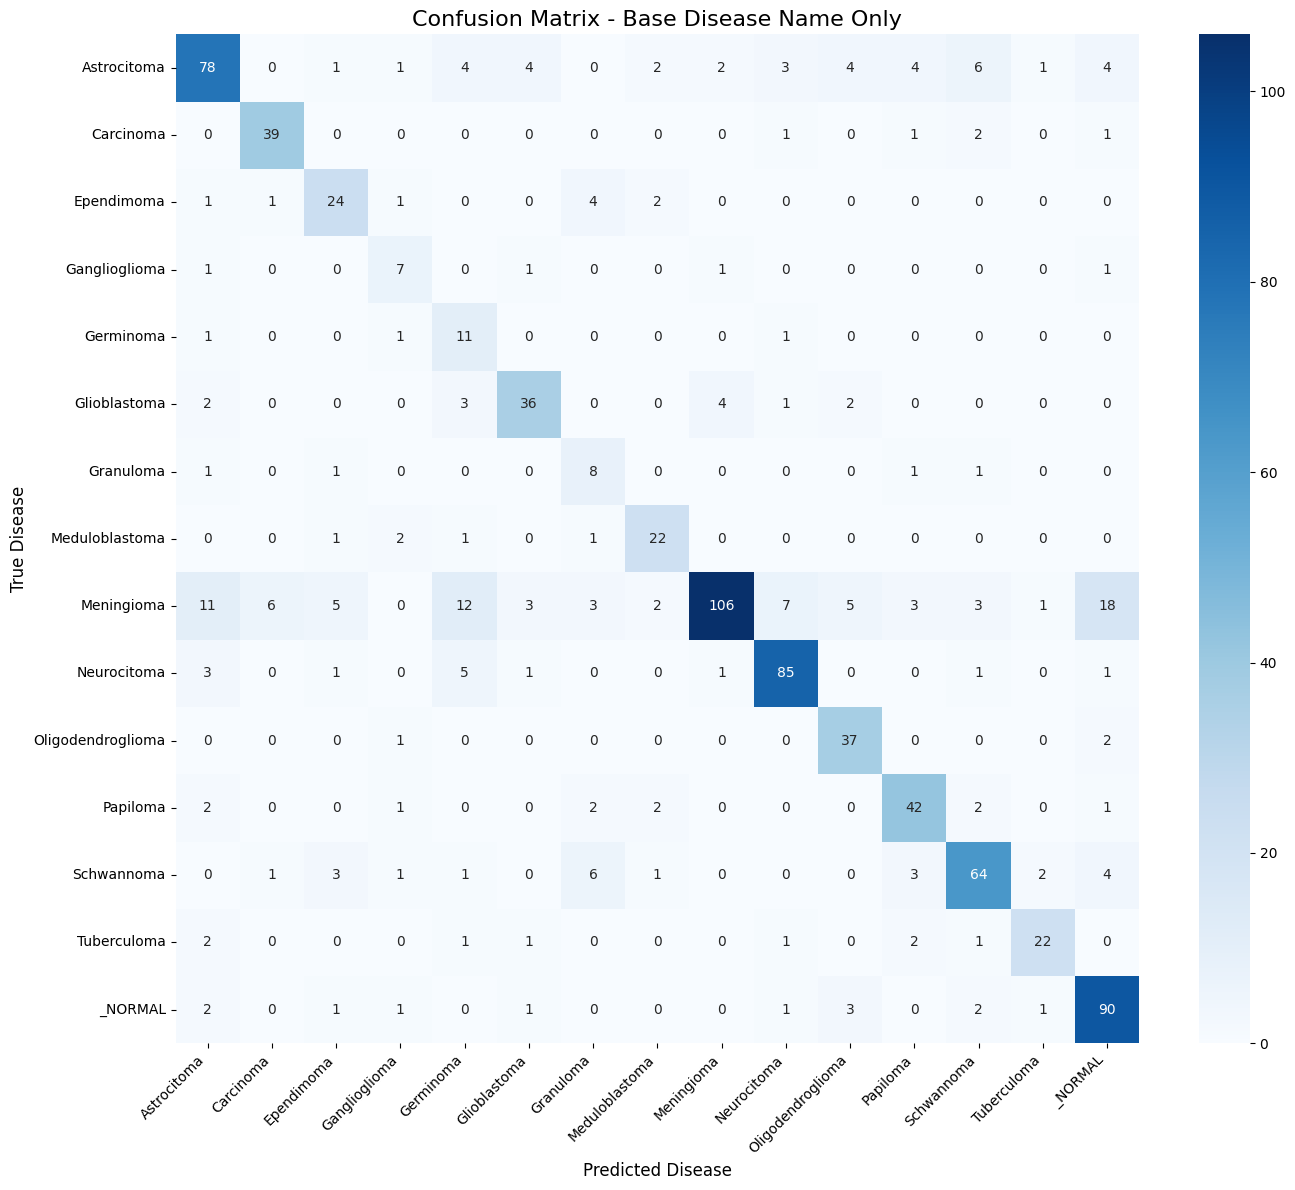

In [21]:
# 3. Plot the Condensed Confusion Matrix
cm_base = confusion_matrix(base_y_true, base_y_pred, labels=base_class_names)

plt.figure(figsize=(14, 12))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', 
            xticklabels=base_class_names, yticklabels=base_class_names)

plt.title('Confusion Matrix - Base Disease Name Only', fontsize=16)
plt.ylabel('True Disease', fontsize=12)
plt.xlabel('Predicted Disease', fontsize=12)

# Rotate the x-axis labels so they are easy to read
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

--- Tumor vs. Normal Detection ---
Binary AUC Score: 0.9823


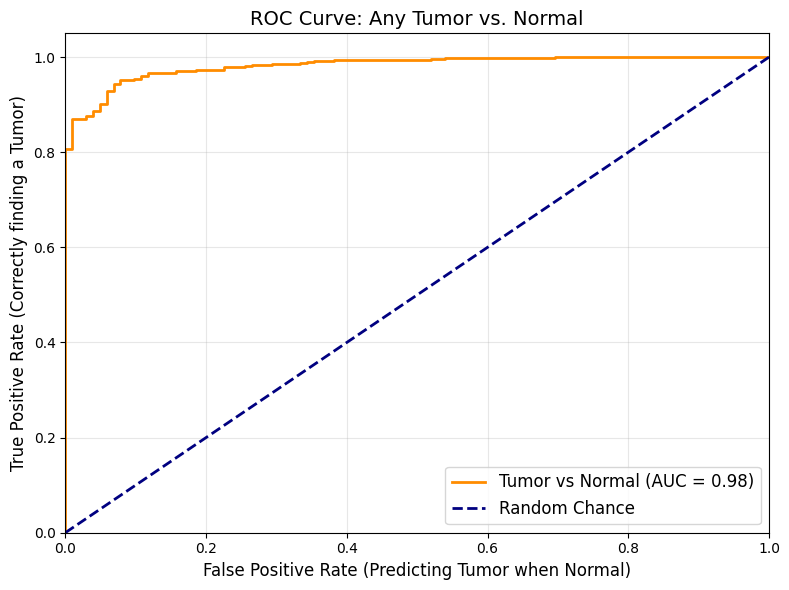

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 1. Create Binary True Labels (0 = Normal, 1 = Tumor)
# We check if the string "_NORMAL" is in the class name for each actual label
binary_y_true = [0 if '_NORMAL' in class_names[label] else 1 for label in y_true]

# 2. Calculate the Binary "Tumor" Probability
# For each image, we sum up the predicted probabilities of all 42 tumor classes. 
# This gives us the total probability that the image contains ANY tumor.
binary_y_probs = []
for probs in y_probs:
    tumor_prob = 0.0
    for i, p in enumerate(probs):
        if '_NORMAL' not in class_names[i]:
            tumor_prob += p
    binary_y_probs.append(tumor_prob)

# 3. Calculate the standard Binary ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(binary_y_true, binary_y_probs)
binary_auc = auc(fpr, tpr)

print(f"--- Tumor vs. Normal Detection ---")
print(f"Binary AUC Score: {binary_auc:.4f}")

# 4. Plot the clean, single-line ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Tumor vs Normal (AUC = {binary_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Predicting Tumor when Normal)', fontsize=12)
plt.ylabel('True Positive Rate (Correctly finding a Tumor)', fontsize=12)
plt.title('ROC Curve: Any Tumor vs. Normal', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
import torch
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score

def get_batch_accuracies(model, dataloader, steps=10):
    model.eval() # Ensure model is in evaluation mode
    accs = []
    
    # Create an iterator from your PyTorch validation dataloader
    data_iter = iter(dataloader)
    
    with torch.no_grad():
        for _ in range(steps):
            try:
                # Grab the next batch of images and labels
                inputs, labels = next(data_iter)
            except StopIteration:
                # Break the loop if we run out of batches before hitting 'steps'
                break 
                
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Move tensors back to CPU for Scikit-Learn calculation
            preds = preds.cpu().numpy()
            actual = labels.cpu().numpy()
            
            accs.append(accuracy_score(actual, preds))
            
    return accs

# 1. Get EfficientNetV2 accuracies across 10 validation batches
efficientnet_accs = get_batch_accuracies(model, dataloaders['val'], steps=10)

# 2. Baseline (Simulated values for demonstration)
# When you have your actual baseline model trained, you would run: 
# baseline_accs = get_batch_accuracies(baseline_model, dataloaders['val'], steps=10)
baseline_accs = [acc - np.random.uniform(0.02, 0.05) for acc in efficientnet_accs]

# 3. Perform the Paired T-Test
t_stat, p_val = stats.ttest_rel(efficientnet_accs, baseline_accs)

print("\n--- Statistical Comparison (Paired T-Test) ---")
print(f"EfficientNetV2 Mean Batch Acc: {np.mean(efficientnet_accs):.4f}")
print(f"Baseline Mean Batch Acc:       {np.mean(baseline_accs):.4f}")
print("-" * 40)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value:     {p_val:.4f}\n")

if p_val < 0.05:
    print("Result: Statistically Significant Difference (EfficientNetV2 is better).")
else:
    print("Result: No Statistically Significant Difference.")


--- Statistical Comparison (Paired T-Test) ---
EfficientNetV2 Mean Batch Acc: 0.7063
Baseline Mean Batch Acc:       0.6685
----------------------------------------
T-statistic: 11.9431
P-value:     0.0000

Result: Statistically Significant Difference (EfficientNetV2 is better).
